# **Value at Risk (VaR) Computing on Stock Returns**

A key factor that forms the backbone for risk management is the measure of those potential losses that an institution is exposed to any investment. Various risk measures are used for this purpose and Value at Risk (VaR) is the most commonly used risk measure to quantify the level of risk and implement risk management.

VaR is typically defined as **the maximum loss which should not be exceeded during a specific time period with a given probability level** (or ‘confidence level’). VaR is used extensively to determine the level of risk exposure of an investment, portfolio or firm and calculate the extent of **potential losses**. Thus, VaR attempts to measure the risk of unexpected changes in prices (or return rates) within a given period. Mathematically, the VaR corresponds to the quantile of the distribution of returns.

The two key elements of VaR are a fixed period of time over which risk is assessed and a confidence level which is essentially the probability of the occurrence of loss-causing event. There are various methods used to compute the VaR. In this coding projects, 



I discuss in detail the historical method which is a popular way of estimating VaR.


## **Pre-Settings**

In [239]:
# Importing libraries
import yfinance as yf
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats

## **Data**

To fetch stock data, I use [Yahoo Finance](https://finance.yahoo.com) in Python. It makes relatively easy and accesible to retrieve historical stock data. 

You can look up additional tickers and listed companies but here is a list of the now [Trending Tickers](https://finance.yahoo.com/lookup/)

**Intervals**:
- "1m": 1 minute
- "60m": 1 hour
- "1d": 1 day (default frequency)
- "1wk": 1 week
- "1mo": 1 month

In [234]:
# Define the stock ticker symbol
ticker = "AAPL"

# Fetch the stock data with a 1-hour frequency
stock_data = yf.download(ticker, start="2010-01-01", end="2025-01-01", interval="1d", progress=False)

A **Rate of Return (ROR)** is the gain or loss of an investment over a certain period of time. In other words, the rate of return is the gain (or loss) compared to the cost of an initial investment, typically expressed in the form of a percentage. When the ROR is positive, it is considered a gain, and when the ROR is negative, it reflects a loss on the investment. Its formula:

$$
R = \frac{V_t - V_{t-1}}{V_{t-1}}, \quad \text{where} \quad R = \text{return}, \; V_t = \text{price at time}\ t, \; V_{t-1} = \text{price at time} \ t-1.
$$

In [235]:
# Calculating the rate of return
daily_return = stock_data['Close', ticker].pct_change().dropna()

## **Historical Method**

In [8]:
def historical_var(returns, alpha):
    sorted_returns = np.sort(returns)
    var_index = int(alpha * len(sorted_returns))
    return -sorted_returns[var_index]

- This method calculates the VaR by sorting the historical returns and identifying the loss at a specific percentile (e.g., 5th percentile for a 95% confidence level).
- The outcome depends on past returns and is non-parametric, meaning it doesn’t assume any specific distribution.

In [242]:
alpha = 5
VaR_hist = historical_var(daily_return, alpha/100)
print(f"{round(VaR_hist*100, 2)}%")

2.66%


The **Value at Risk (VaR)** calculated with the **historical method** is `2.66%`. It means that based on historical returns data, there is a `2.66%` probability that the loss on the portfolio or asset will exceed this value over a day.

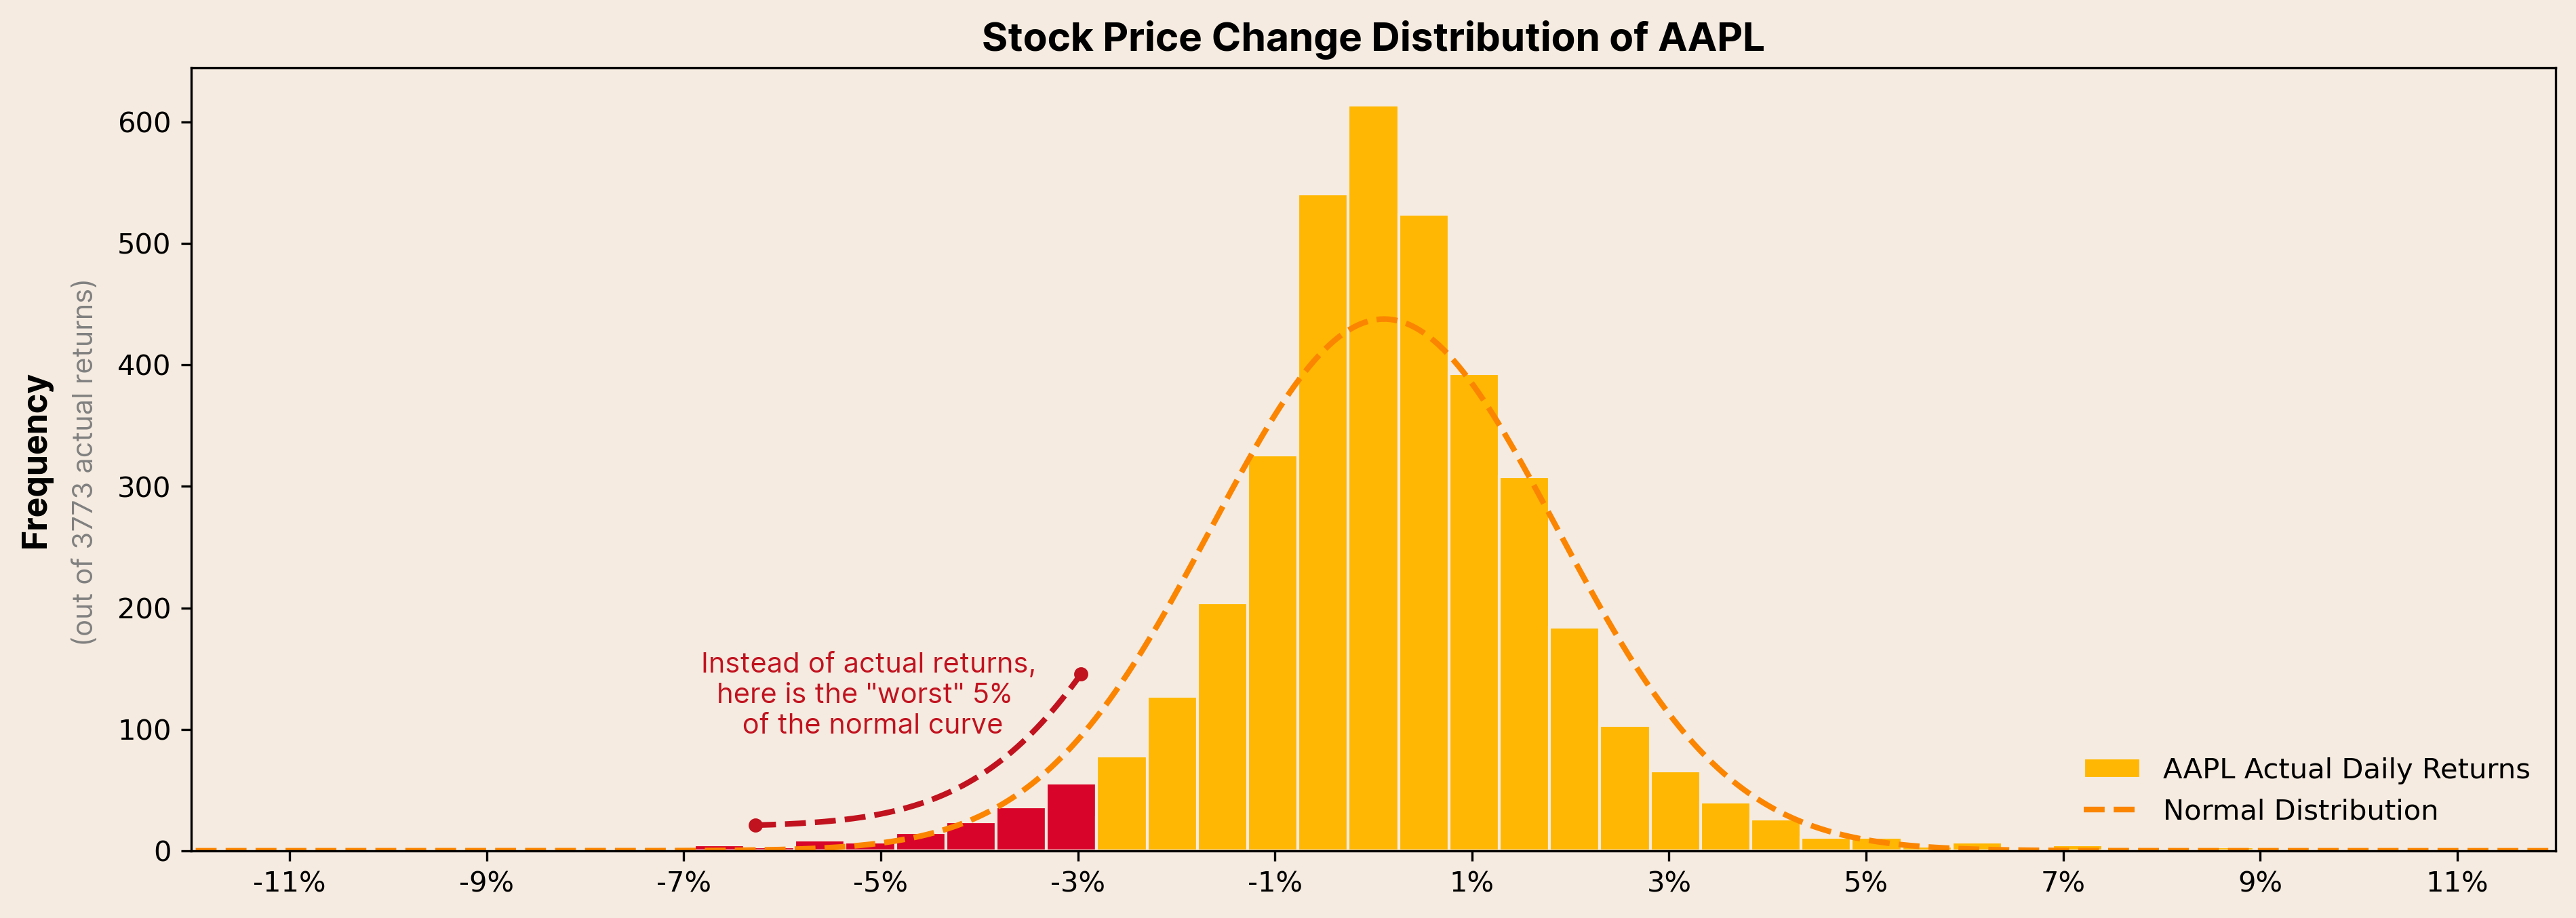

In [238]:
# Histogram

# Calculate mean and standard deviation for the normal distribution
mean = np.mean(daily_return)
std = np.std(daily_return)

# Create bins
bins = np.linspace(-0.12, 0.12, 48)

# Generate data for the normal distribution curve
x = np.linspace(min(daily_return), max(daily_return), 1000)
y = norm.pdf(x, mean, std) * len(daily_return) * (bins[1] - bins[0])  # Scale to match histogram

# Plot the histogram
plt.figure(figsize=(15, 5), dpi=300)

# Change the background color of the plot
plt.gcf().set_facecolor("#f5ebe0")  # Set figure background color
plt.gca().set_facecolor("#f5ebe0")  # Set axes background color

# Plot the first 5% with a different color
plt.hist(
    daily_return[daily_return <= -VaR_hist], 
    bins=bins, 
    linewidth=1, 
    edgecolor="#f5ebe0", 
    color='#d90429', 
    rwidth=1,  # Add spacing between bars
    label=""
)

# Plot the rest of the histogram
plt.hist(
    daily_return[daily_return > -VaR_hist], 
    bins=bins, 
    linewidth=1, 
    edgecolor="#f5ebe0", 
    color='#ffb703', 
    rwidth=1,  # Add spacing between bars
    label=(ticker + " Actual Daily Returns")
)

# Plot the normal distribution curve
plt.plot(x, y, color="#fb8500", linestyle="--", linewidth=2, label="Normal Distribution")
# Plot the VaR distribution curve phase
x_var = x[(x >= -0.06) & (x <= -VaR_hist)] - 0.003
y_var = y[(x >= -0.06) & (x <= -VaR_hist)] + 20
plt.plot(x_var, y_var, color="#c1121f", linestyle="--", linewidth=2, label="", marker="o", markevery=[0, -1], markersize=4)


# Set x-axis ticks and labels
ticks = np.arange(-11, 12, 2) / 100  # Generate ticks from -11% to 11% with a step of 2%
tick_labels = [f"{int(tick * 100)}%" for tick in ticks]
plt.xticks(ticks, tick_labels)

# Set x-axis range
plt.xlim(-0.12, 0.12)

# Add labels, title, and legend
plt.title('Stock Price Change Distribution of ' + ticker, fontsize=14, fontfamily="Inter", fontweight="bold")

plt.gca().set_ylabel("Frequency\n", fontsize=12, labelpad=10, fontfamily="Inter", fontweight="bold")  # Larger font for the first line
plt.gca().text(
    -0.132,  # x-coordinate (adjust to place it correctly near the y-axis)
    320,    # y-coordinate (adjust to position below 'Frequency')
    f"(out of {len(daily_return)} actual returns)", 
    fontsize=10,  # Smaller font size for the second line
    rotation=90,  # Rotate vertically to match the axis
    verticalalignment='center',  # Center align text along y-axis
    fontfamily="Inter",
    color='gray'
)

#
t = (f"Instead of actual returns,\nhere is the \"worst\" {alpha}% \n of the normal curve")
plt.text(st.median(x_var)-0.005, 100, t, family='Inter', ha='center', wrap=True, color="#c1121f")

# Customize the legend
plt.legend(
    loc='lower right',
    fontsize=10,
    frameon=False,
)

# Show the plot
plt.show()


## **Variance-Covariance Method**

In [240]:
def variance_covariance_var(returns, alpha):
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    z_score = stats.norm.ppf(alpha)
    return -(mean_return + z_score * std_dev)

- This method assumes that returns are normally distributed and calculates VaR based on the mean and standard deviation of historical returns.
- It uses the Z-score corresponding to the chosen confidence level (e.g., 1.645 for 95% confidence) to estimate the potential loss.

In [241]:
alpha = 5
VaR_covar = historical_var(daily_return, alpha/100)
print(f"{round(VaR_covar*100, 2)}%")

2.66%


The output from both the **historical method** and the **variance-covariance method** is the same (`2.66%`), it suggests that both methods are estimating the same risk level for the given portfolio or asset, despite using different approaches. 

This is not uncommon, and it can happen when the assumptions and data used by both methods lead to similar results.

**Normal Distribution Approximation**: If the returns of the asset or portfolio being analyzed are approximately normally distributed, the variance-covariance method’s estimate could be very similar to the historical method's estimate. This is because the historical returns may also align closely with a normal distribution, where the historical loss at the 5th percentile is close to the loss predicted by the parametric method (based on the standard deviation and mean).



## **Monte Carlo Method**

In [243]:
def monte_carlo_var(returns, alpha, num_simulations=10000):
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    simulated_returns = np.random.normal(mean_return, std_dev, num_simulations)
    sorted_simulated_returns = np.sort(simulated_returns)
    var_index = int(alpha * len(sorted_simulated_returns))
    return -sorted_simulated_returns[var_index]

The **Monte Carlo method** uses a *simulation* approach to generate a large number of random returns (or price paths) based on a model of the asset's behavior (such as assuming normal distribution). The method then calculates the VaR by sorting these simulated outcomes and finding the loss at a specific percentile (e.g., 5th percentile for 95% confidence).

In [244]:
alpha = 5
VaR_monte = monte_carlo_var(daily_return, alpha/100)
print(f"{round(VaR_monte*100, 2)}%")

2.76%


`2.76%` is a **slightly larger Value at Risk (VaR)** using the **Monte Carlo method** compared to the historical and variance-covariance methods, it could be due to the differences in how these methods estimate potential losses.

## **Comparison of Methods**:
- **Historical Method**: Based purely on observed past returns, it reflects how the asset actually behaved in the past. This doesn't account for potential future extreme events that didn't occur historically but could theoretically happen.
- **Variance-Covariance (Parametric) Method**: Assumes returns follow a normal distribution (or some other specified distribution) and uses the mean and standard deviation to calculate VaR. It might underestimate risk in cases where extreme events or non-normal distributions are present.
- **Monte Carlo Method**: Allows for more flexibility in simulating complex models and considering extreme scenarios, which could result in a higher VaR if the simulations include more extreme events than the historical or normal distribution assumptions.